<a href="https://colab.research.google.com/github/mdna-j/CS471/blob/main/CS_471_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Reproducibility Bootstrap ---
import os, random, numpy as np

# Limited threads for deterministic results
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["PYTHONHASHSEED"] = "42"

# Global seeds
random.seed(42)
np.random.seed(42)

# Pin versions
!pip -q install --upgrade --no-input scikit-learn==1.4.2 imbalanced-learn==0.12.3 kagglehub

print("Bootstrap set. Now do: Runtime → Restart session, then run the next cell.")


Bootstrap set. Now do: Runtime → Restart session, then run the next cell.


In [ ]:
# --- IMPORTANT: Download Kaggle dataset ---
import kagglehub
mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

print('Data source import complete.')

# Confirms dataset location
!ls "$mlg_ulb_creditcardfraud_path"


Data source import complete.
creditcard.csv


scikit-learn: 1.4.2
numpy: 2.0.2
pandas: 2.2.2
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


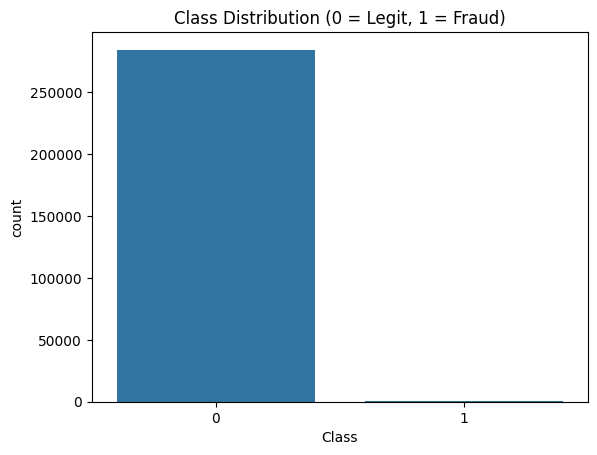

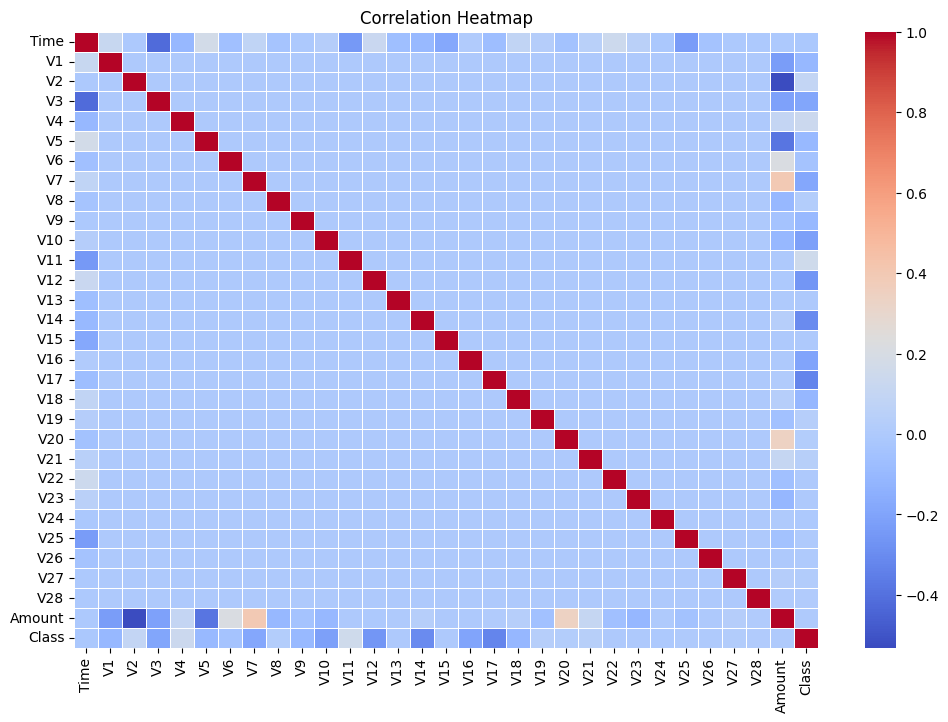

Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8454    0.8367    0.8410        98

    accuracy                         0.9995     56962
   macro avg     0.9225    0.9182    0.9204     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion Matrix:
[[56849    15]
 [   16    82]]
AUC Score: 0.9731024901519414


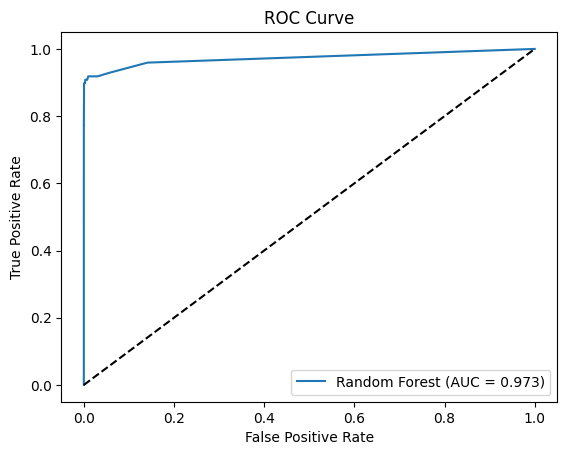

Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9987    0.9988     56864
           1     0.3084    0.3367    0.3220        98

    accuracy                         0.9976     56962
   macro avg     0.6536    0.6677    0.6604     56962
weighted avg     0.9977    0.9976    0.9976     56962

Confusion Matrix:
[[56790    74]
 [   65    33]]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import random, numpy as np, warnings

# Reseed again
random.seed(42)
np.random.seed(42)

warnings.filterwarnings("ignore")

# Versions for reproducibility tracking
print(f"scikit-learn: {sklearn_version}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")

# Load dataset
df = pd.read_csv(f"{mlg_ulb_creditcardfraud_path}/creditcard.csv")

# EDA
print(df['Class'].value_counts(normalize=True))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Legit, 1 = Fraud)')
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Preprocess
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])
X, y = df.drop('Class', axis=1), df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Model 1: Random Forest
rf = RandomForestClassifier(
    n_estimators=100, random_state=42, n_jobs=1, bootstrap=True
)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("AUC Score:", roc_auc_score(y_test, y_proba_rf))

fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Model 2: Isolation Forest
iso_forest = IsolationForest(contamination=0.001727, random_state=42)
iso_forest.fit(X_train)
y_pred_iso = np.where(iso_forest.predict(X_test) == -1, 1, 0)

print("Isolation Forest Classification Report:")
print(classification_report(y_test, y_pred_iso, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))
